# Sales Predictive analysis

## Prediction of store sales using LSTM



### Importing necessary libraries

In [1]:
import sys
import os
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

import joblib
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam


import tensorflow as tf

In [2]:
# Sales Predictive analysis
sys.path.append(os.path.abspath('../scripts'))
from Utils import DataUtils
from Custom_Transformers import MissingDataHandler, OutlierHandler, ProperDtypes, DateFeatures, Scaler

data_utils = DataUtils()


In [3]:
# Loading data
store = data_utils.load_data('store.csv')
train = data_utils.load_data('train.csv')
test = data_utils.load_data('test.csv')

2024-09-24 18:49 - DEBUG :: Loading data from file...
2024-09-24 18:49 - DEBUG :: Loading data from file...
2024-09-24 18:49 - DEBUG :: Loading data from file...


### Preprocessing: Isolating dataset into time series data

In [4]:
train_store = train.merge(store, on='Store', how='inner')
test_store = test.merge(store, on='Store', how = 'inner')

test_store.drop('Id', axis=1, inplace=True)
train_store.drop('Customers', axis=1, inplace=True)

train_store = train_store.sort_values(by='Date')
test_store = test_store.sort_values(by='Date')

train.loc[train['StateHoliday'] == '0', 'StateHoliday'] = 'Not StateHoliday'
test.loc[train['StateHoliday'] == '0', 'StateHoliday'] = 'Not StateHoliday'
X = train_store.drop('Sales', axis=1)
y = train_store.Sales

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = test_store

In [5]:
# Preprocessing pipeline
missing_cols = ['CompetitionDistance', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Promo2SinceWeek', 'Promo2SinceYear', 'Open']
cat_missing_cols = ['PromoInterval']
outlier_col = ['CompetitionDistance']
to_int_cols = ['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceYear']
scale_cols = list(X_train.select_dtypes(exclude='object').columns)


preprocess_pipeline = Pipeline([
    ('missing_handler', MissingDataHandler(strategy='constant', fill_value=0, cols= missing_cols)),
    ('Cat_missing_handler', MissingDataHandler(strategy='constant', fill_value='No Promo', cols= cat_missing_cols)),
    ('Outlier_handler', OutlierHandler(method='IQR', cols=outlier_col)),
    ('Proper_dtypes', ProperDtypes(cols=to_int_cols, proper_type='int64')), 
    ('Proper_dtypes_obj', ProperDtypes(cols='StateHoliday', proper_type=str)),
    ('Feature_engineering', DateFeatures()), 
    ('Scaler', Scaler(cols=scale_cols, scaler_type = 'MinMaxScaler')),
    ('Encoder', OrdinalEncoder()),
])


train_processed = preprocess_pipeline.fit_transform(X_train)
val_processed = preprocess_pipeline.transform(X_val)
test_processed = preprocess_pipeline.transform(X_test)

2024-09-24 18:49 - DEBUG :: Adding holiday column...
2024-09-24 18:49 - DEBUG :: Adding holiday column...
2024-09-24 18:49 - DEBUG :: Adding holiday column...


In [ ]:
train_processed_reshaped = train_processed.reshape(train_processed.shape[0], train_processed.shape[1], 1)
val_processed_reshaped = val_processed.reshape(val_processed.shape[0], val_processed.shape[1], 1)

y_train_seq = y_train
y_val_seq = y_val

### Check whether your time Series Data is Stationary

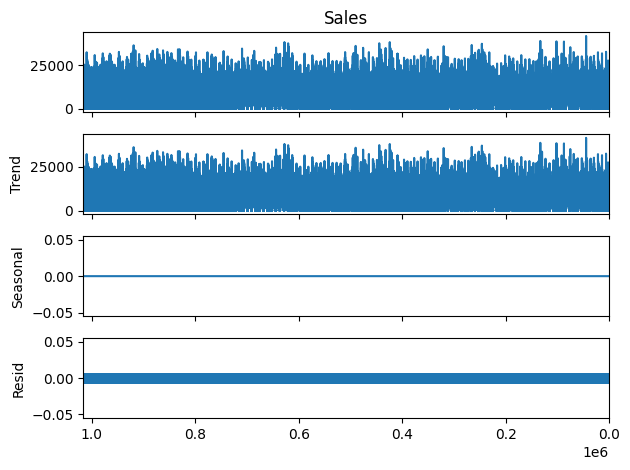

In [48]:
series = y # <- y == train['Sales']
result = seasonal_decompose(series, model='additive', period=1)
result.plot()
plt.show()

**Observation**
- We can see that the data is stationary
- There is no seasonality observed 

#### Plot for autocorrelation and partial autocorrelation

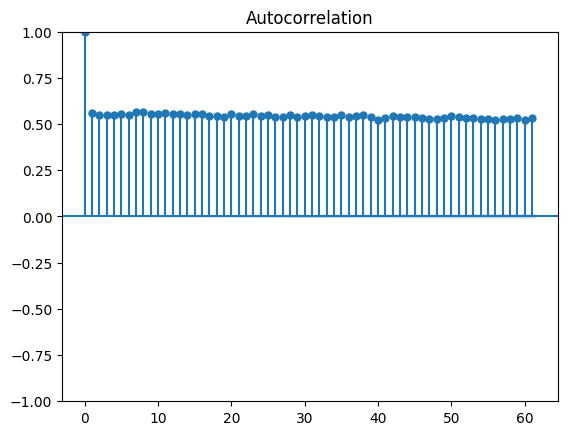

In [29]:
series = y  # <- y == train['Sales']
plot_acf(series)
plt.show()

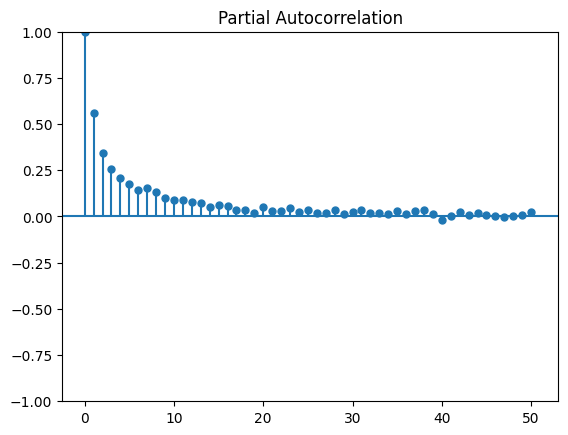

In [30]:
series = y  # <- y == train['Sales']
plot_pacf(series, lags=50)
plt.show()

#### Build Regression model using Vanilla LSTM

In [31]:
tf.random.set_seed(42)
  

model1 = Sequential()
model1.add(InputLayer(shape=(7, 1)))

model1.add((LSTM(64, activation='tanh', return_sequences=False)))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1, activation='linear'))

model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,425 (68.07 KB)

 Trainable params: 17,425 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

In [32]:
from datetime import datetime
time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
cp = ModelCheckpoint(f'model_{time}.keras', save_best_only=True)

# initial_lr = 0.1
# lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_lr, decay_steps=10000)

model1.compile(
    loss = MeanSquaredError(),
    optimizer = Adam(learning_rate=0.01), 
    metrics=[RootMeanSquaredError()]
)

In [33]:
callback = EarlyStopping(monitor='loss',
                                              patience=3)
history1 = model1.fit(train_processed_reshaped, y_train_seq, validation_data=(val_processed_reshaped, y_val_seq),
                    epochs=1000, callbacks=[cp, callback], batch_size = 128, verbose=0)

In [34]:
time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f'model_{time}.keras'
model1.save(filename)

print("Saved model", filename)

Saved model model_2024-09-24_12-39-20.keras


In [35]:
y_pred = model1.predict(val_processed_reshaped)


6358/6358 ━━━━━━━━━━━━━━━━━━━━ 33s 5ms/step


In [36]:
mean_absolute_error(y_pred, y_val_seq)

1454.785776361201

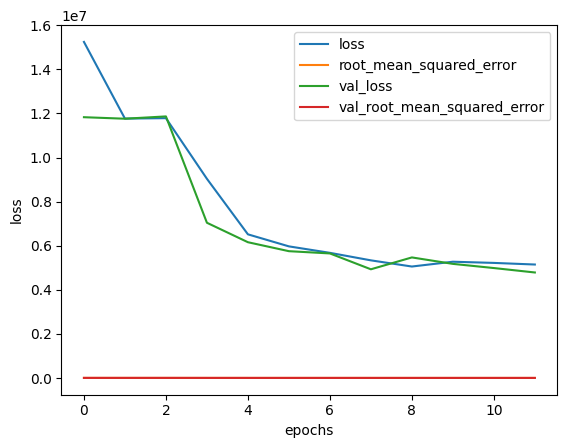

In [37]:
pd.DataFrame(history1.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");

#### Build Regression model using Bidirectional LSTM

In [38]:
tf.random.set_seed(42)


model2 = Sequential()
model2.add(InputLayer(shape=(7, 1)))

model2.add(Bidirectional(LSTM(64, activation='tanh', return_sequences=False)))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(1, activation='linear'))

model2.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │         1,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,833 (136.07 KB)

 Trainable params: 34,833 (136.07 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
cp = ModelCheckpoint(f'model_{time}.keras', save_best_only=True)

# initial_lr = 0.1
# lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_lr, decay_steps=10000)

model2.compile(
    loss = MeanSquaredError(),
    optimizer = Adam(learning_rate=0.01), 
    metrics=[RootMeanSquaredError()]
)

In [40]:
callback = EarlyStopping(monitor='loss',
                                              patience=3)
history2 = model2.fit(train_processed_reshaped, y_train_seq, validation_data=(val_processed_reshaped, y_val_seq),
                    epochs=1000, callbacks=[cp, callback], batch_size = 128, verbose=0)

In [41]:
time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f'model_{time}.keras'
model2.save(filename)

print("Saved model", filename)

Saved model model_2024-09-24_13-20-50.keras


In [42]:
y_pred = model2.predict(val_processed_reshaped)
mean_absolute_error(y_pred, y_val_seq)

6358/6358 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step


1365.3913480833276

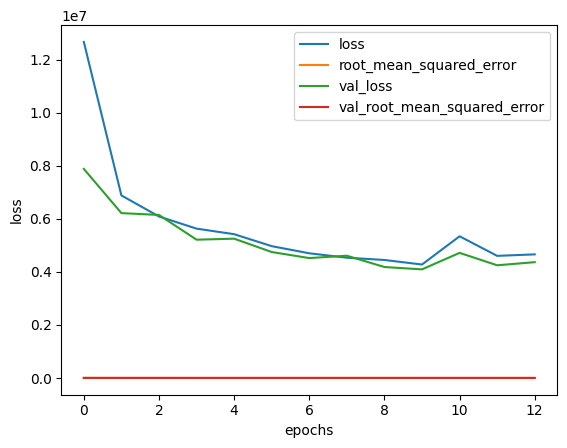

In [43]:
pd.DataFrame(history2.history).plot()
plt.ylabel("loss")
plt.xlabel("epochs");